In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras import layers, models, datasets, preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

drive.mount('/content/drive/')

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

#Take out data set and shuffle it
data = tf.keras.utils.image_dataset_from_directory('drive/MyDrive/data', image_size = IMAGE_SIZE, batch_size = BATCH_SIZE)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Found 4188 files belonging to 4 classes.


In [ ]:
#Scale the images down to make for more efficient testing
data = data.map(lambda x,y: (x/255, y))

class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

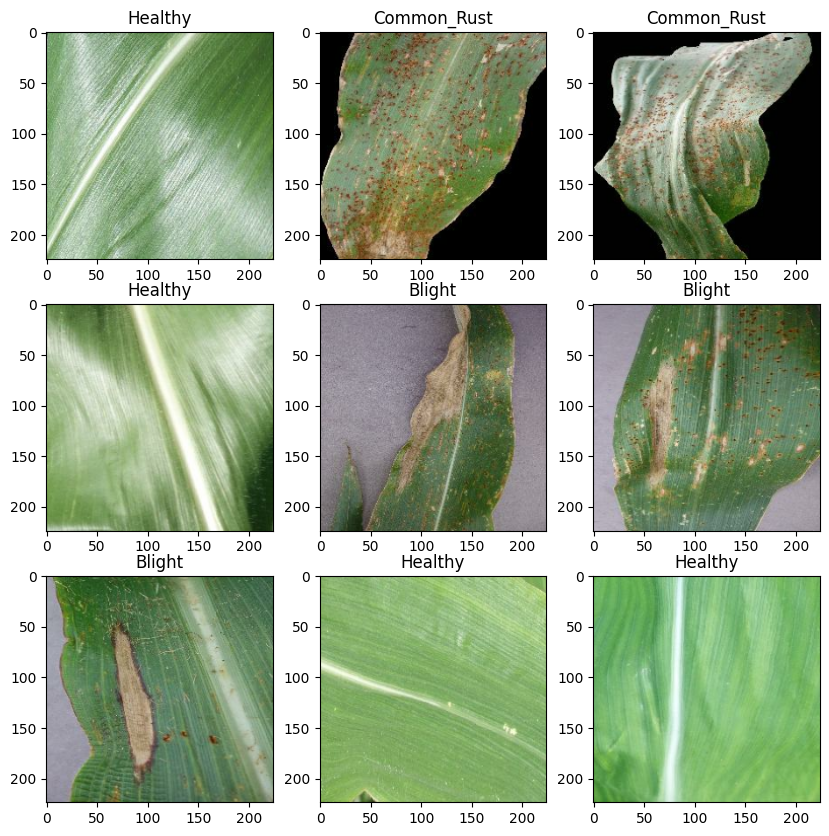

In [ ]:
#Show what a batch looks like and make sure it's returning the proper image.
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols=3, nrows = 3, figsize = (10,10))
for idx, img in enumerate(batch[0][:9]):
  row = idx // 3
  col = idx % 3
  ax[row,col].imshow(img)
  ax[row,col].title.set_text(class_names[batch[1][idx]])

In [ ]:
#Partition data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int((len(data) - val_size - train_size))

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (224,224,3))

# Create a new model on top of the base VGG16 model
model = Sequential([
    base_model,  # Add the VGG16 base model
    Flatten(),   # Flatten the output of the VGG16 model
    Dense(256, activation='relu'),  # Add a fully connected layer
    Dense(4, activation='softmax')  # Add the output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

epochs = 100

history = model.fit(train, epochs = epochs, batch_size = BATCH_SIZE, validation_data = val, callbacks = [early_stopping])

Epoch 1/100
91/91 [==============================] - 37s 173ms/step - loss: 1.1884 - accuracy: 0.8513 - val_loss: 61.9533 - val_accuracy: 0.3341
Epoch 2/100
91/91 [==============================] - 15s 164ms/step - loss: 0.3268 - accuracy: 0.9052 - val_loss: 46.4665 - val_accuracy: 0.2704
Epoch 3/100
91/91 [==============================] - 15s 164ms/step - loss: 0.2921 - accuracy: 0.9172 - val_loss: 54.2074 - val_accuracy: 0.2993
Epoch 4/100
91/91 [==============================] - 15s 165ms/step - loss: 0.1869 - accuracy: 0.9334 - val_loss: 45.4070 - val_accuracy: 0.4772
Epoch 5/100
91/91 [==============================] - 15s 162ms/step - loss: 0.1622 - accuracy: 0.9468 - val_loss: 71.8096 - val_accuracy: 0.4459
Epoch 6/100
91/91 [==============================] - 15s 164ms/step - loss: 0.1733 - accuracy: 0.9468 - val_loss: 32.0933 - val_accuracy: 0.3257
Epoch 7/100
91/91 [==============================] - 15s 163ms/step - loss: 0.1221 - accuracy: 0.9591 - val_loss: 25.8518 - val_ac

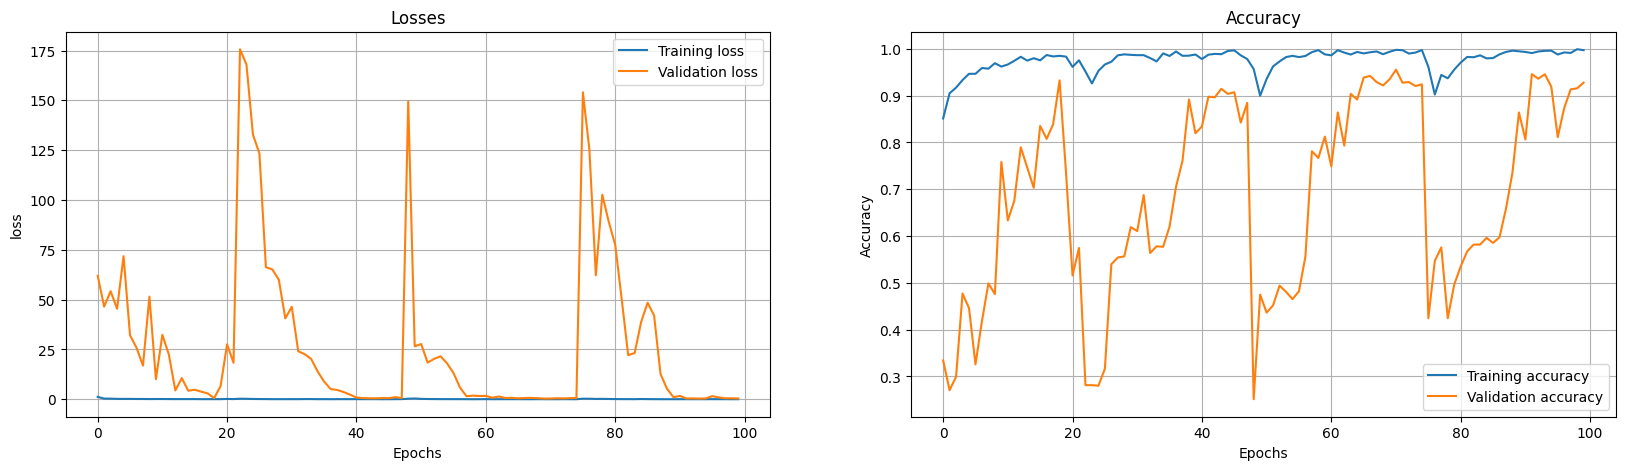

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
predicted_classes = []
true_labels = []
y_score = []
for images, labels in test:
    # Predict probabilities for each class
    predictions_prob = model.predict(images)
    y_score.extend(predictions_prob)
    # Convert probabilities to class labels
    predicted_class = predictions_prob.argmax(axis=1)

    # Append true labels and predicted classes to the lists
    true_labels.extend(labels.numpy())  # Convert labels tensor to numpy array
    predicted_classes.extend(predicted_class)

1/1 [==============================] - 1s 809ms/step


In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
accuracy = accuracy_score(true_labels, predicted_classes)

0.8986486486486487

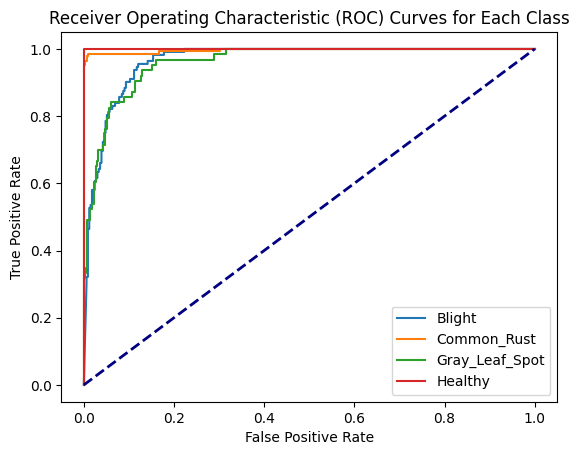

<Figure size 800x600 with 0 Axes>

In [ ]:
for i in range(4):
  y_true_binary = np.array([1 if label == i else 0 for label in true_labels])

  fpr, tpr, _ = roc_curve(y_true_binary, np.array(y_score)[:,i], drop_intermediate=False)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label=f'{class_names[i]}')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
plt.legend(loc="lower right")
plt.figure(figsize=(8, 6))
plt.show()

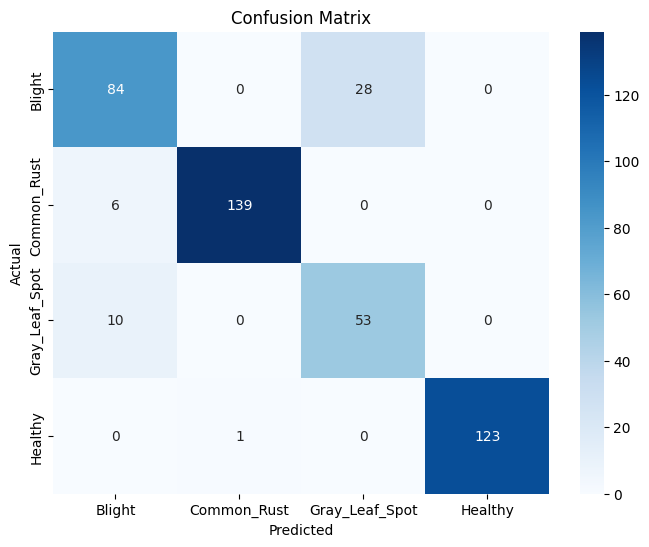

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_classes)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()